# **CSCI-497 - Final Project - Model Training**
### Group 2
Members:
- Cade Mock (50350556)
- Grayson Goates (50331095)

(4/20/2025)

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

In [ ]:
df = pd.read_csv("/content/yellow_tripdata-2025-01-cleaned.csv") # change to the location of your cleaned data file
print(df.isnull().sum())  # check for NaN values in the dataframe
print("Null counts in total_amount:", df["total_amount"].isnull().sum())

trip_distance           0
PULocationID            0
DOLocationID            0
fare_amount             0
extra                   0
total_amount            0
congestion_surcharge    0
Airport_fee             0
pickup_date             0
pickup_day              0
pickup_time             0
dropoff_date            0
dropoff_day             0
dropoff_time            0
dtype: int64
Null counts in total_amount: 0


In [ ]:
from google.colab import drive # mounting our google drive when attempting to save models later on
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = df.drop(columns=["fare_amount", "total_amount"])
y = df["total_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42) # 80/20 split
feature_names = X.columns # save column names for later use with feature importance or other visualizations, if we need it
print("Data loaded and split into train/test sets.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
print("Null count in y_train:", y_train.isnull().sum())
print("Null count in y_test:", y_test.isnull().sum())
print("Null count in X_train:", X_train.isnull().sum().sum())
print("Null count in X_test:", X_test.isnull().sum().sum())

Data loaded and split into train/test sets.
Training set size: 668303 samples
Test set size: 167076 samples
Number of features: 12
Null count in y_train: 0
Null count in y_test: 0
Null count in X_train: 0
Null count in X_test: 0


Here above, we split the data and select total amount as our target variable. As stated in the proposal, this is used so the standard variables that could account for the total cost of taxi use are taken into consideration.

# 1. Baseline Models

We will begin my implementing two baseline models to compare our later results with. This will better help us verify the results with our more advanced models. We will start with a Mean Predictor and Linear Regression model.

### Dummy Regression (Mean predictor)

In [ ]:
print("\nTraining Dummy Regressor (Mean)...")
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)


Training Dummy Regressor (Mean)...


## Linear Regression

In [ ]:
print("Training Linear Regression model...")
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

Training Linear Regression model...


## 2. Cross-Validation

To better allow us to establish the baseline models, we will use cross-validation on the mean regressor and the linear regressor using RMSE as the metric. This will provide us with an effective reference point to further analyze the efficiency of our main models later.

In [ ]:
# References:
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error
# https://scikit-learn.org/stable/modules/cross_validation.html

print("\nPerforming cross-validation on baseline models...")

# Cross-validation for Dummy Regressor
# Dummy regressor will serve as our baseline model that makes simple predictions
# using basic strategies like predicting the mean, in this case
dummy_cv_scores = cross_val_score(
    DummyRegressor(strategy="mean"),
    X, y,
    cv=5, # 5-fold cross-validation
    scoring='neg_root_mean_squared_error' # RMSE score, negative because sklearn maximizes scores
)

# Print mean and standard deviation of RMSE scores across the folds
# The negative sign will convert our scores back to postive RMSE
print(f"Dummy Regressor CV RMSE: {-dummy_cv_scores.mean():.4f} ± {dummy_cv_scores.std():.4f}")

# Cross-validation for Linear Regression
linear_cv_scores = cross_val_score(
    LinearRegression(), # Standard Linear regression model, default params
    X, y,
    cv=5,
    scoring='neg_root_mean_squared_error'
)
print(f"Linear Regression CV RMSE: {-linear_cv_scores.mean():.4f} ± {linear_cv_scores.std():.4f}")


Performing cross-validation on baseline models...
Dummy Regressor CV RMSE: 1.0007 ± 0.0187
Linear Regression CV RMSE: 0.5775 ± 0.1217


## 3. Random Forest Model

This Random Forest model will be the initial main model. From our proposal and research, we have seen that a Random Forest model is a very good algorithm for our type of predictions and data.

In [ ]:
# References:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# https://www.ibm.com/think/topics/random-forest
# https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/

print("\nTraining initial Random Forest model...")

# Initialize a Random Forest regressor with specified params
# n_estimators=100: The number of decision trees in the forest, this can be tweaked
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred_rf = rf_model.predict(X_test)


Training initial Random Forest model...


## 4. Hyperparameter Tuning

In this notebook, I edited the grid search to use a subsection of data using only 50,000 samples to speed up the process. I am running this alongside a full in-depth grid search, and a 100,000 item subset random search.

P.S:
Our Gridsearch with subset model turned out to be the highest performing model we could get running with the limited Google Colab RAM availability.

In [ ]:
# References:
# https://stats.stackexchange.com/questions/550399/what-is-the-role-of-shuffle-in-train-test-split
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# https://scikit-learn.org/stable/modules/grid_search.html
# https://www.w3schools.com/python/python_ml_grid_search.asp
# https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/
# https://medium.com/data-science/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Create a smaller subset of training data for efficiency and due to limitations
# This approach reduces computational requirements while still capturing a good amount of data patterns
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train,
    train_size=min(50000, X_train.shape[0]),  # Use at most 50,000 samples, or all available samples if fewer (when dataset is limited)
    random_state=42,
    shuffle=True # Using shuffle prevents potential ordering bias, since we are taking a susbet
)
print(f"Created subset with {X_sub.shape[0]} samples for hyperparameter tuning")

# Define the parameter grid for the hyperparameter search, could play around with this
# Each parameter is tested with multiple values to find an optimal combination
param_grid = {
    'n_estimators': [50, 100, 200], # Number of trees in the forest
    'max_depth': [None, 10, 20, 30], # Maximum depth of each tree (None = unlimited)
    'min_samples_split': [2, 5, 10], # Minimum samples required to split a tree branch
    'min_samples_leaf': [1, 2, 4] # Minimum samples required to be a leaf node
}

# Set up GridSearchCV to perform a full search over specified parameter values
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42), # Base estimator
    param_grid, # The parameter grid to search
    cv=5, # 5-fold cross-validation
    scoring='neg_root_mean_squared_error', # Optimization metric (minimize the RMSE)
    n_jobs=-1  # Use all available cores (unsure if this works on Google Colab)
)

# Fit the grid search to the data subset
print("Running grid search on the subset...")
grid_search.fit(X_sub, y_sub)
print(f"Best parameters: {grid_search.best_params_}")

# Create a new model with the optimal parameters found by the grid search
# then, train it on the full training dataset
print("Training best model on full dataset...")
best_rf = RandomForestRegressor(random_state=42, **grid_search.best_params_) # Unpack the best parameters from the grid search
best_rf.fit(X_train, y_train) # Train on the full dataset
y_pred_best_rf = best_rf.predict(X_test) # Make predictions

Created subset with 50000 samples for hyperparameter tuning
Running grid search on the subset...
Best parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Training best model on full dataset...


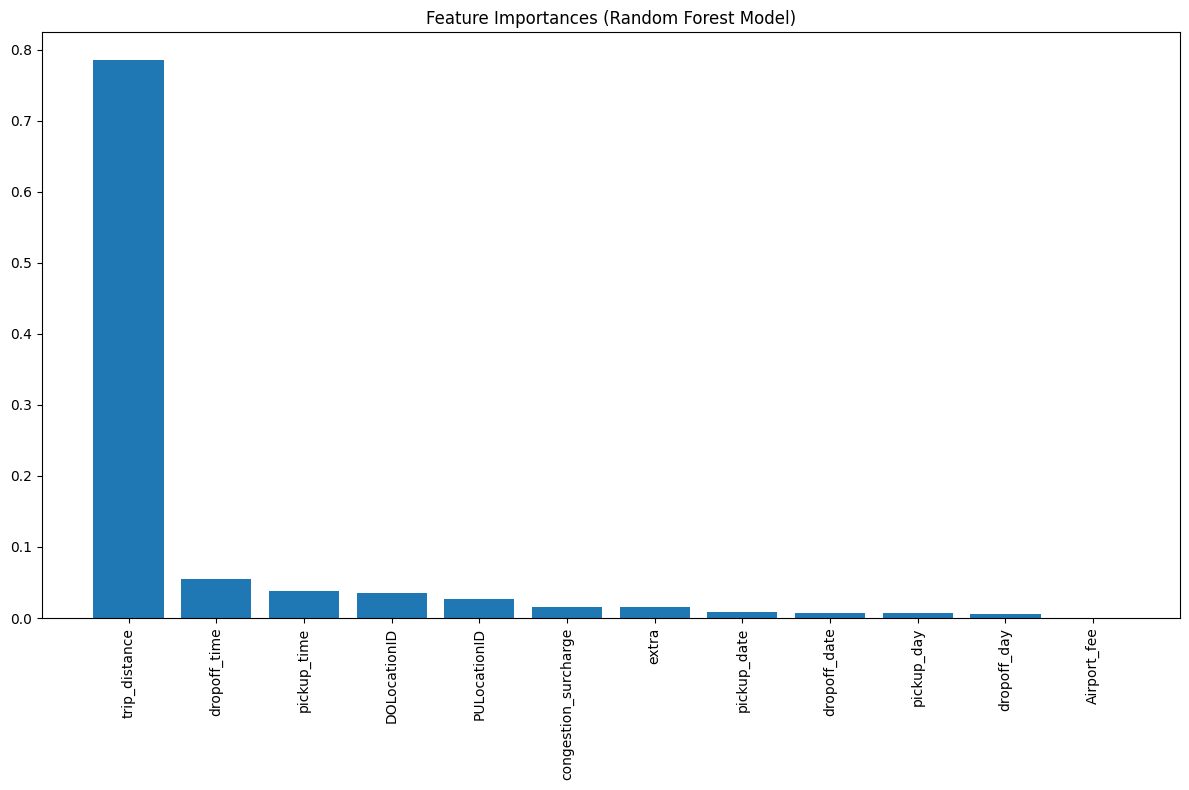


Feature importance ranking:
1. trip_distance: 0.7853
2. dropoff_time: 0.0556
3. pickup_time: 0.0379
4. DOLocationID: 0.0356
5. PULocationID: 0.0273
6. congestion_surcharge: 0.0157
7. extra: 0.0148
8. pickup_date: 0.0082
9. dropoff_date: 0.0074
10. pickup_day: 0.0067
11. dropoff_day: 0.0053
12. Airport_fee: 0.0001


In [ ]:
# References:
# https://www.geeksforgeeks.org/feature-importance-with-random-forests/
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python

# Create a visualization of feature importances derived from the best Random Forest model
plt.figure(figsize=(12, 8))

# Extract feature importances from the trained model
# feature_importances_ is a property that tree-based models have that
# measures the average "reduction in impurity" across all trees
importances = best_rf.feature_importances_

# Sort importances in descending order to show most important features first
indices = np.argsort(importances)[::-1]

# Create the bar chart with feature importances
plt.title('Feature Importances (Random Forest Model)')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')

# Set the x-axis labels to feature names of the features (rotated for visibility)
# feature_names is a list of all the features in X, which we defined earlier
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Print the numerical ranking of feature importances
print("\nFeature importance ranking:")
for i in range(len(feature_names)):
    # rank, feature name, and importance value
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

## 5. Try Gradient Boosting

This model will assist us further in future analysis with our main model to better understand its effectiveness. As stated in our proposal, we will implement Gradient Boosting and other ensemble methods to test the effectiveness of Random Forest in this context.

In [ ]:
# References:
# https://www.displayr.com/gradient-boosting-the-coolest-kid-on-the-machine-learning-block/
# https://www.geeksforgeeks.org/ml-gradient-boosting/

print("\nTraining Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)


Training Gradient Boosting Regressor...


## 6. Create a simple ensemble model  
## (weighted average)

In [ ]:
# References:
# https://scikit-learn.org/stable/modules/ensemble.html
# https://medium.com/@shashank25.it/ensemble-methods-in-machine-learning-2d4cc7513c77
# https://machinelearningmastery.com/weighted-average-ensemble-with-python/
# https://medium.com/analytics-vidhya/simple-weighted-average-ensemble-machine-learning-777824852426

print("\nCreating ensemble model...")
# Combine the predictions from multiple models to imrpove the overall performance
# This method implements a weighted ensemble based on the model performance

# Calculate the RMSE for each model on the test set
# Lower RMSE means better performance
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_rf)) # RMSE for Random Forest
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb)) # RMSE for Gradient Boosting

# Calculate weights inversely proportional to RMSE
# Models with lower errors get higher weights
rf_weight = 1/rf_rmse # Weight for Random Forest predictions
gb_weight = 1/gb_rmse # Weight for Gradient Boosting predictions
total_weight = rf_weight + gb_weight # Sum of weights

# Calculate ensemble predictions using the weighted averae
# Each model's prediction is weighted by its inverse RMSE and normalized
y_pred_ensemble = (
    (rf_weight * y_pred_best_rf + gb_weight * y_pred_gb) / total_weight
)


Creating ensemble model...


## 7. Calculate Metrics for all models

In [ ]:
print("\nCalculating performance metrics...")

# Calculate MSE, RMSE, MAE, and R2 for all models
dummy_mse = mean_squared_error(y_test, y_pred_dummy)
dummy_rmse = np.sqrt(dummy_mse)
dummy_mae = mean_absolute_error(y_test, y_pred_dummy)
dummy_r2 = r2_score(y_test, y_pred_dummy)

linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_rmse = np.sqrt(linear_mse)
linear_mae = mean_absolute_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)

rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

best_rf_mse = mean_squared_error(y_test, y_pred_best_rf)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_mae = mean_absolute_error(y_test, y_pred_best_rf)
best_rf_r2 = r2_score(y_test, y_pred_best_rf)

gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

ensemble_mse = mean_squared_error(y_test, y_pred_ensemble)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_mae = mean_absolute_error(y_test, y_pred_ensemble)
ensemble_r2 = r2_score(y_test, y_pred_ensemble)

# Print results
print("\n===== Model Performance =====")
print("\nDummy Regressor (Mean):")
print(f"MSE: {dummy_mse:.4f}")
print(f"RMSE: {dummy_rmse:.4f}")
print(f"MAE: {dummy_mae:.4f}")
print(f"R2: {dummy_r2:.4f}")

print("\nLinear Regression:")
print(f"MSE: {linear_mse:.4f}")
print(f"RMSE: {linear_rmse:.4f}")
print(f"MAE: {linear_mae:.4f}")
print(f"R2: {linear_r2:.4f}")

print("\nRandom Forest (Initial):")
print(f"MSE: {rf_mse:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R2: {rf_r2:.4f}")

print("\nRandom Forest (Tuned):")
print(f"MSE: {best_rf_mse:.4f}")
print(f"RMSE: {best_rf_rmse:.4f}")
print(f"MAE: {best_rf_mae:.4f}")
print(f"R2: {best_rf_r2:.4f}")

print("\nGradient Boosting:")
print(f"MSE: {gb_mse:.4f}")
print(f"RMSE: {gb_rmse:.4f}")
print(f"MAE: {gb_mae:.4f}")
print(f"R2: {gb_r2:.4f}")

print("\nEnsemble Model:")
print(f"MSE: {ensemble_mse:.4f}")
print(f"RMSE: {ensemble_rmse:.4f}")
print(f"MAE: {ensemble_mae:.4f}")
print(f"R2: {ensemble_r2:.4f}")


Calculating performance metrics...

===== Model Performance =====

Dummy Regressor (Mean):
MSE: 1.0021
RMSE: 1.0010
MAE: 0.8098
R2: -0.0000

Linear Regression:
MSE: 0.2645
RMSE: 0.5143
MAE: 0.3841
R2: 0.7361

Random Forest (Initial):
MSE: 0.1650
RMSE: 0.4062
MAE: 0.3026
R2: 0.8354

Random Forest (Tuned):
MSE: 0.1631
RMSE: 0.4039
MAE: 0.2999
R2: 0.8372

Gradient Boosting:
MSE: 0.2027
RMSE: 0.4502
MAE: 0.3336
R2: 0.7978

Ensemble Model:
MSE: 0.1728
RMSE: 0.4157
MAE: 0.3080
R2: 0.8276


Above, we can see all the results of the models we have trained. As of right now, our Random Forest tuned to using grid search on a subset of data points is the best performing, as we predicted and saw in our proposal. However, our ensemble model is currently doing poorly in comparison to just our Random Forest, which is not the outcome we desire.</br></br>

Let's try training a Stacking Ensemble model with additional features. This will be a much more complex model than our simple ensemble that was predicting worse than our tuned Random Forest model.

# 8. Stacking Ensemble

In [ ]:
# Some of these may be unused after multiple iterations of experiments and testing
# But, just make sure we reimport things we need and use commonly
# DevTools in other programs can identify unused imports later on
from sklearn.model_selection import KFold, train_test_split
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import gc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone

In [ ]:
print("\nBuilding improved stacking ensemble...")

# Check if the small training subset already exists, and create it if not
# If you recall, we previously had a segmented training subset - but for consistency sake,
# we will redefine one here
if 'X_train_subset' not in locals():
    # Create a smaller subset of training data for computational reasons and limitations
    # Stacking models are very intensive, so we were running out of memory using Colab
    subset_size = min(50000, X_train.shape[0]) # Limit to 50k samples or dataset size if smaller
    X_train_subset, _, y_train_subset, _ = train_test_split(
        X_train, y_train,
        train_size=subset_size, # Number of samples to include in the subset
        random_state=42
    )
    print(f"Created subset with {X_train_subset.shape[0]} samples for stacking model")


Building improved stacking ensemble...
Created subset with 50000 samples for stacking model


In [ ]:
# References
# https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/
# https://www.geeksforgeeks.org/support-vector-regression-svr-using-linear-and-non-linear-kernels-in-scikit-learn/
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
# https://medium.com/@vk.viswa/support-vector-regression-unleashing-the-power-of-non-linear-predictive-modeling-d4495836884

# Train a Support Vector Regression model on the subset data
# This smaller subset also helps with SVR because training time scaled poorly with SVR as
# dataset size increases
print("Training SVR model...")

# Initialize the SVR model with specific hyperparameters:
# - kernel='rbf': Radial Basis Function kernel (Gaussian kernel) - effective for non-linear patterns
# - C=10: Regularization parameter - controls trade-off between complexity and error minimialization
#   Higher C values allow the model to use more supper vectors, but can potentially overfit
# - gamma='scale': Kernel coefficient - determines the influence of each support vector
#   In this case, 'scale' means 1/(n_features * X.var()) which makes it adapt to the feature scales automatically
svr_model = SVR(kernel='rbf', C=10, gamma='scale')

# Train the model on the subset data
svr_model.fit(X_train_subset, y_train_subset)

Training SVR model...


SVR(C=10)

In [ ]:
# References:
# https://medium.com/ml-research-lab/stacking-ensemble-meta-algorithms-for-improve-predictions-f4b4cf3b9237
# https://www.sciencedirect.com/science/article/abs/pii/S0950705121011631
# https://stats.stackexchange.com/questions/239445/how-to-properly-do-stacking-meta-ensembling-with-cross-validation
# https://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/

# Set up ensemble structure with the pre-trained base models
# Each base model is stored as a tuple (name, model_object) inside of the base_models array
base_models = [
    ('random_forest', best_rf),  # Tuned Random Forest model from earlier grid search
    ('gradient_boosting', gb_model), # Gradient Boosting model trained previously
    ('svr', svr_model) # SVR model just trained on the data subset
]
model_names = ['Random Forest (Tuned)', 'Gradient Boosting', 'SVR']

# Cross-validation for generating meta-features
k = 5  # Number of folds for the cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42) # KFold object with shuffling to prevent bias

# Initialize array to store "out-of-fold" predictions from the base models
# These predictions will later server as features for the meta-model (stacking ensemble)
meta_features = np.zeros((X_train_subset.shape[0], len(base_models)))

In [ ]:
# References:
# https://airbyte.com/data-engineering-resources/what-is-data-leakage
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html
# https://www.kaggle.com/discussions/getting-started/177975
# https://stackoverflow.com/questions/52396191/what-is-oof-approach-in-machine-learning
# https://scikit-learn.org/0.23/modules/generated/sklearn.base.clone.html
# https://stats.stackexchange.com/questions/239445/how-to-properly-do-stacking-meta-ensembling-with-cross-validation
# https://towardsdatascience.com/how-to-properly-validate-a-model-when-stacking-ad2ee1b2b9c/

# Generate cross-validated predictions to build meta-features for the stacking ensemble
print("Generating cross-validated meta-features...")

# Iterate through each base model
for i, (name, model) in enumerate(base_models):
    print(f"Processing {name}...")

    # Initialize array to store predictions for current model
    # These predictions will become meta-features for the meta-model
    fold_predictions = np.zeros(X_train_subset.shape[0])

    # Perform k-fold cross-validation
    for train_idx, val_idx in kf.split(X_train_subset):
        # Split data for current fold
        # train_idx: indices for training, val_idx: indices for validation
        X_fold_train, X_fold_val = X_train_subset.iloc[train_idx], X_train_subset.iloc[val_idx]
        y_fold_train = y_train_subset.iloc[train_idx]

        # Create a fresh copy of the model for each fold
        # Prevent information leakage between folds
        fold_model = clone(model)

        # Train the model copy on the current fold's training data
        fold_model.fit(X_fold_train, y_fold_train)

        # Generate predictions on the validation portion
        # These predictions are made on data the model hasn't seen during training
        fold_predictions[val_idx] = fold_model.predict(X_fold_val)

    # Store predictions from all folds as meta-features for this model
    # Column i in this meta_features variable contains predictions from model i
    meta_features[:, i] = fold_predictions

    # Free memory (unsure if this is doing anything)
    gc.collect()

Generating cross-validated meta-features...
Processing random_forest...
Processing gradient_boosting...
Processing svr...


In [ ]:
# References:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# https://www.geeksforgeeks.org/ml-gradient-boosting/
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
# https://ignite.apache.org/docs/latest/machine-learning/ensemble-methods/gradient-boosting#:~:text=In%20machine%20learning%2C%20boosting%20is,weak%20learners%20to%20strong%20ones.
# https://scikit-learn.org/stable/modules/ensemble.html

# Train a meta-model for the stacking ensemble
# The meta-model learns to combine the predictions from the base models optimally
print("Training meta-model...")

# Initialize Gradient Boosting Regressor as the meta-model (can experiment with linear regression or xgboost)
# This model will learn to combine the predictions from base models
meta_model = GradientBoostingRegressor(
    n_estimators=200, # Number of boosting stages/trees to build
    learning_rate=0.05, # Shrinks the contribution of each tree for less overfitting
    max_depth=4, # Maximum depth of individual regression trees
    subsample=0.8, # Fraction of samples used for fitting individual trees, reduces overfitting
    random_state=42
)

# Train the meta-model
meta_model.fit(meta_features, y_train_subset)

Training meta-model...


GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=200,
                          random_state=42, subsample=0.8)

In [ ]:
# References:
# # Generate predictions from base models on test set
test_meta_features = np.zeros((X_test.shape[0], len(base_models)))
for i, (name, model) in enumerate(base_models):
    test_meta_features[:, i] = model.predict(X_test)

# Make final predictions
# y_pred_stacked = meta_model.predict(test_meta_features)
# https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28
# https://www.frontiersin.org/journals/neurorobotics/articles/10.3389/fnbot.2024.1391247/full
# https://www.sciencedirect.com/science/article/pii/S2405959522001345
# https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/

# Generate predictions from all base models on the test set
# These predictions will serve as input features for the meta-model
test_meta_features = np.zeros((X_test.shape[0], len(base_models)))

# iterate through each base model to get predictions
for i, (name, model) in enumerate(base_models):
  # Generate and store predictions from each base model
  # We are using the full pre-trained models here
  test_meta_features[:, i] = model.predict(X_test)

# Apply the meta-model to the base model predictions
y_pred_stacked = meta_model.predict(test_meta_features)

In [ ]:
# References:
# https://www.sciencedirect.com/science/article/pii/S1386505623001089
# https://pubmed.ncbi.nlm.nih.gov/37172507/
# https://datascience.stackexchange.com/questions/96693/feature-selection-using-stacking-ensemble
# https://cienciadedatos.net/documentos/py52-stacking-ensemble-models-forecasting.html
# https://skforecast.org/0.11.0/faq/stacking-ensemble-models-forecasting

# Evaluate the stacking ensemble on the test data
rmse_stacked = np.sqrt(mean_squared_error(y_test, y_pred_stacked)) # Root Mean Squared Error
r2_stacked = r2_score(y_test, y_pred_stacked) # Coefficient of determination, R2

# Predictions and performance metrics
print("\nImproved Stacking Ensemble Predictions (first 5):", y_pred_stacked[:5])
print(f"Improved Stacking Ensemble RMSE: {rmse_stacked:.4f}")
print(f"Improved Stacking Ensemble R2 Score: {r2_stacked:.4%}")

# Analyze the contribution of each base model to the ensemble
# This will show which models are most valuable in the meta-model's decision process
feature_importance = meta_model.feature_importances_ # Importance scores from meta-model
print("\nMeta-model Feature Importance:")
for name, importance in zip(model_names, feature_importance):
    print(f"{name}: {importance:.4f}") # Display each model's importance score


Improved Stacking Ensemble Predictions (first 5): [-0.56713822 -0.87134206  0.31140488  2.23887255  0.4838953 ]
Improved Stacking Ensemble RMSE: 0.3192
Improved Stacking Ensemble R2 Score: 89.8347%

Meta-model Feature Importance:
Random Forest (Tuned): 0.3636
Gradient Boosting: 0.1597
SVR: 0.4767


In [ ]:
# Create a comparison of all models
model_results = {
    'Random Forest (Initial)': {'RMSE': rf_rmse, 'R2': rf_r2},
    'Random Forest (Tuned)': {'RMSE': best_rf_rmse, 'R2': best_rf_r2},
    'Gradient Boosting': {'RMSE': gb_rmse, 'R2': gb_r2},
    'Linear Regression': {'RMSE': linear_rmse, 'R2': linear_r2},
    'Dummy Regressor': {'RMSE': dummy_rmse, 'R2': dummy_r2},
    'Simple Ensemble': {'RMSE': ensemble_rmse, 'R2': ensemble_r2},
    'Stacking Ensemble': {'RMSE': rmse_stacked, 'R2': r2_stacked}
}

# Convert to DataFrame for easier visualization
# Enables easier sorting/visualization/comaprison
results_df = pd.DataFrame({
    'Model': list(model_results.keys()), # Model names as a column
    'RMSE': [model_results[m]['RMSE'] for m in model_results], # Extract RMSE values
    'R2': [model_results[m]['R2'] for m in model_results] # Extract R2 values
})

# Display sorted results with best performing models (lowest RMSE) at the top
print("\nModel Comparison:")
print(results_df.sort_values('RMSE')) # Sort by RMSE in ascending order


Model Comparison:
                     Model      RMSE            R2
6        Stacking Ensemble  0.319165  8.983474e-01
1    Random Forest (Tuned)  0.403860  8.372392e-01
0  Random Forest (Initial)  0.406152  8.353865e-01
5          Simple Ensemble  0.415679  8.275733e-01
2        Gradient Boosting  0.450180  7.977630e-01
3        Linear Regression  0.514260  7.360912e-01
4          Dummy Regressor  1.001049 -3.295944e-08


# Visualization of Model Results

#### The following visualization will assist in demonstrating the combined results of RMSE and R2 of each model. The implementation is below and the results will be analyzed following the graphs.

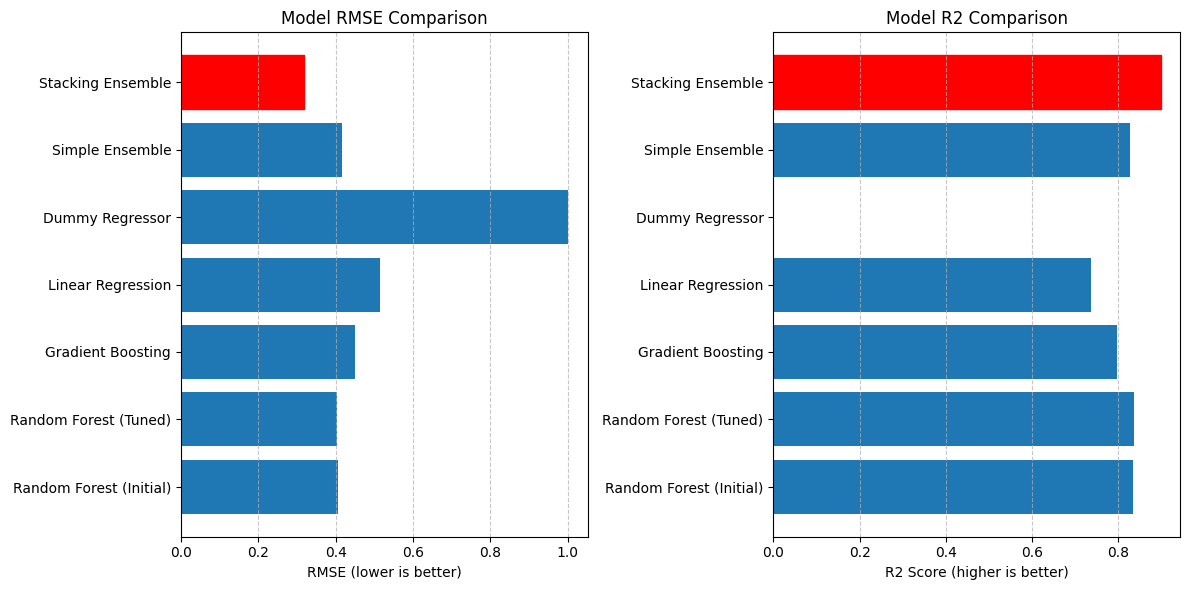

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))

# Plot RMSE metrics (left subplot)
# Lower values indicate better model performance
plt.subplot(1, 2, 1)
bars = plt.barh(results_df['Model'], results_df['RMSE'])
plt.xlabel('RMSE (lower is better)')
plt.title('Model RMSE Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Highlight the Stacking Ensemble to highlight it as the best performing
for i, bar in enumerate(bars):
    if results_df['Model'].iloc[i] == 'Stacking Ensemble':
        bar.set_color('red')

# Plot R2 metrics (right subplot)
# Higher values indicate better model performance
plt.subplot(1, 2, 2)
bars = plt.barh(results_df['Model'], results_df['R2'])
plt.xlabel('R2 Score (higher is better)')
plt.title('Model R2 Comparison')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add the highlight for the Stacking Ensemble in this plot as well
for i, bar in enumerate(bars):
    if results_df['Model'].iloc[i] == 'Stacking Ensemble':
        bar.set_color('red')

plt.tight_layout()
plt.show()

It can be seen that we achieved our goal here of having Stacking Ensemble outperform Random forest. This improvement is very encouraging to see and demonstrates the outcome that we wished to see.

# Error Analysis

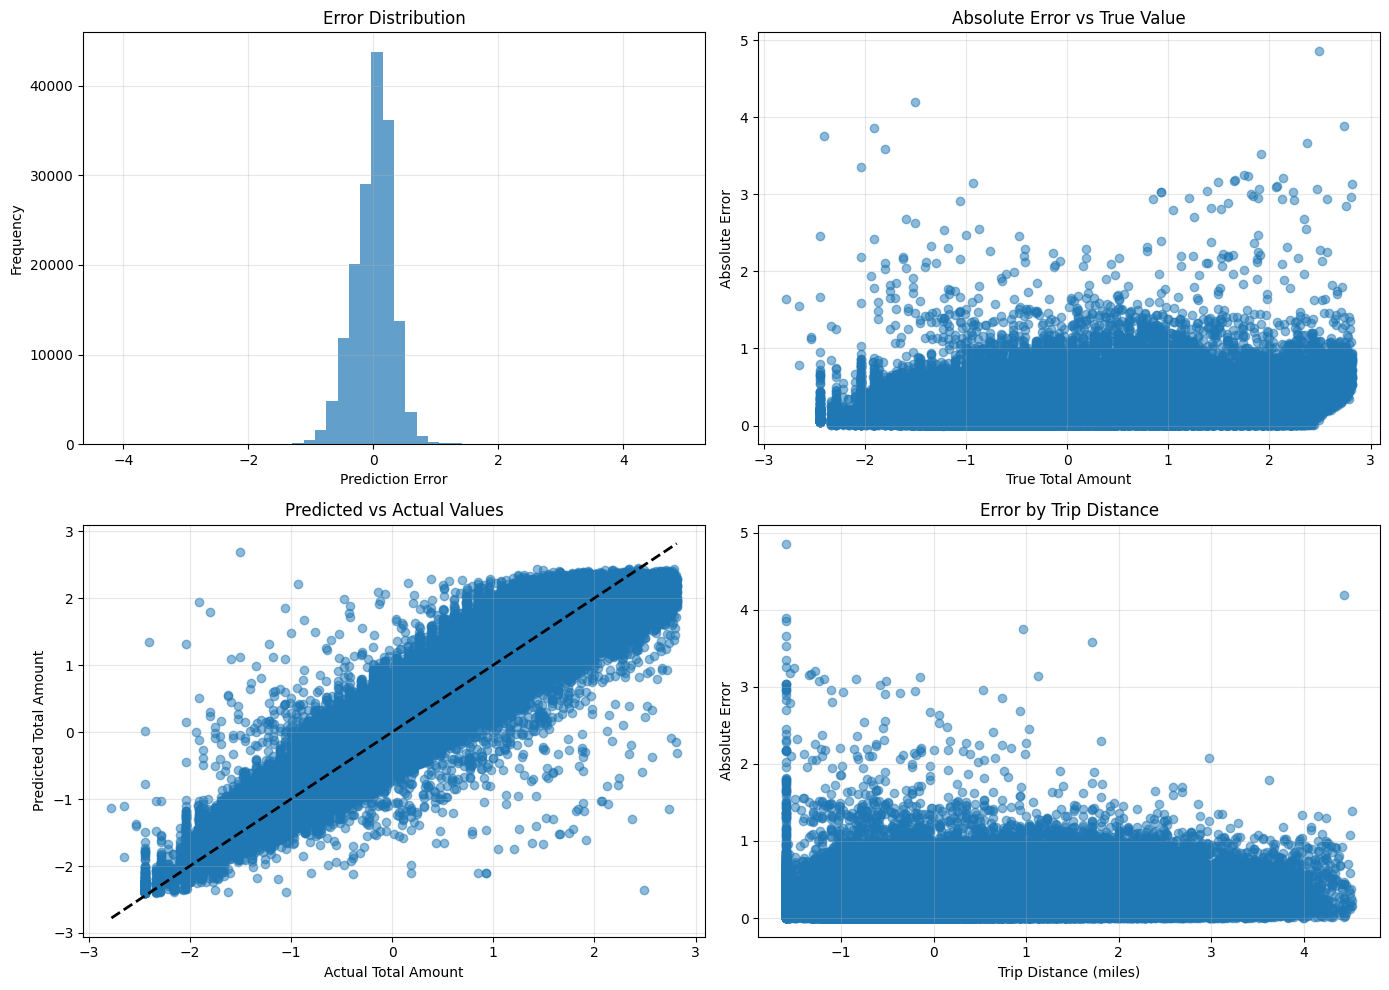


Worst predictions:
True: $1.75, Predicted: $-1.50, Error: $3.26, Trip Distance: -1.59 miles
True: $-2.04, Predicted: $1.31, Error: $-3.35, Trip Distance: -1.59 miles
True: $1.92, Predicted: $-1.61, Error: $3.52, Trip Distance: -1.59 miles
True: $-1.80, Predicted: $1.79, Error: $-3.58, Trip Distance: 1.71 miles
True: $2.37, Predicted: $-1.29, Error: $3.66, Trip Distance: -1.59 miles
True: $-2.41, Predicted: $1.34, Error: $-3.75, Trip Distance: 0.96 miles
True: $-1.91, Predicted: $1.94, Error: $-3.86, Trip Distance: -1.59 miles
True: $2.74, Predicted: $-1.15, Error: $3.89, Trip Distance: -1.59 miles
True: $-1.50, Predicted: $2.69, Error: $-4.19, Trip Distance: 4.43 miles
True: $2.49, Predicted: $-2.37, Error: $4.86, Trip Distance: -1.59 miles

Mean absolute error by day of week:
Day 1: $0.24
Day 2: $0.24
Day 3: $0.25
Day 4: $0.25
Day 5: $0.24
Day 6: $0.24
Day 7: $0.24

Mean absolute error by pickup location (top 5 most common):
Pickup Location ID 237: $0.22
Pickup Location ID 236: $0.21

In [ ]:
# Comprehensive error analysis for best model (stacking ensemble)
# Calculate both raw errors and absolute errors for different analyses
errors = y_test - y_pred_stacked # Signed errors, negative = overestimation, positive = underestimation
abs_errors = np.abs(errors) # Absolute errors

plt.figure(figsize=(14, 10))

# 1. Histogram of error distribution
# Shows the pattern and spread of prediction errors, ideally centered around zero
plt.subplot(2, 2, 1)
plt.hist(errors, bins=50, alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# 2. Absolute error vs true value
# Shows if error magnitude depends on the target value ('heteroscedasticity' check)
plt.subplot(2, 2, 2)
plt.scatter(y_test, abs_errors, alpha=0.5)
plt.title('Absolute Error vs True Value')
plt.xlabel('True Total Amount')
plt.ylabel('Absolute Error')
plt.grid(True, alpha=0.3)

# 3. Predicted vs Actual values
# Shows overall prediction accuracy; points should ideally lie on the diagonal line
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_stacked, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Total Amount')
plt.ylabel('Predicted Total Amount')
plt.grid(True, alpha=0.3)

# 4. Error by trip distance
# Shows if errors are related to a specific feature (trip distance in this case)
plt.subplot(2, 2, 4)
plt.scatter(X_test['trip_distance'], abs_errors, alpha=0.5)
plt.title('Error by Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Absolute Error')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze the worst predictions to identify patterns in major errors
n_worst = 10 # Number of worst predictions to analyze
worst_idx = np.argsort(abs_errors)[-n_worst:] # Indices of largest absolute errors
print("\nWorst predictions:")
for idx in worst_idx:
    print(f"True: ${y_test.iloc[idx]:.2f}, Predicted: ${y_pred_stacked[idx]:.2f}, "
          f"Error: ${errors.iloc[idx]:.2f}, Trip Distance: {X_test.iloc[idx]['trip_distance']:.2f} miles")

# Analyze error patterns across different categorical features (days of the week in this first case)
print("\nMean absolute error by day of week:")
for day in range(1, 8):  # 1 = Monday, 7 = Sunday
    day_mask = X_test['pickup_day'] == day # Create boolean mask for this day
    if day_mask.any(): # Check if any trips occurred on this day
        # Calculate mean absolute error for this day's trips
        day_mae = mean_absolute_error(y_test[day_mask], y_pred_stacked[day_mask])
        print(f"Day {day}: ${day_mae:.2f}")

# Now, by pikcup location to identify any patterns
print("\nMean absolute error by pickup location (top 5 most common):")
top_locations = X_test['PULocationID'].value_counts().nlargest(5).index # Find 5 most common pickup locations
for loc in top_locations: # Check if any trips occurred from this location
    loc_mask = X_test['PULocationID'] == loc # Create boolean mask for this location
    if loc_mask.any():
      # Calculate mean absolute error for trips from this location
        loc_mae = mean_absolute_error(y_test[loc_mask], y_pred_stacked[loc_mask])
        print(f"Pickup Location ID {loc}: ${loc_mae:.2f}")

# we could do any further analysis still here on different features

# Attempt To Save Models For Future Use

In [ ]:
# References:
# https://scikit-learn.org/stable/model_persistence.html
# https://medium.com/@rajatghosh/model-persistence-using-sklearn-9ee25b12b58
# https://joblib.readthedocs.io/en/latest/persistence.html

import joblib

# Save the stacking ensemble components to Google Drive
print("\nSaving final model...")
# Create a directory for models if it doesn't exist
import os
models_dir = '/content/drive/My Drive/nyc_taxi_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

# Save models to Google Drive
joblib.dump(best_rf, f'{models_dir}/nyc_taxi_rf_model.pkl') # Save Random Forest model
joblib.dump(gb_model, f'{models_dir}/nyc_taxi_gb_model.pkl') # Save Gradient Boosting model
joblib.dump(svr_model, f'{models_dir}/nyc_taxi_svr_model.pkl') # Save Support Vector Regressor
joblib.dump(meta_model, f'{models_dir}/nyc_taxi_meta_model.pkl') # Save meta-model (final layer)

print("Models saved successfully to Google Drive!")


Saving final model...
Models saved successfully to Google Drive!


# Dependence Plot
(Show how specific features affect predictions)

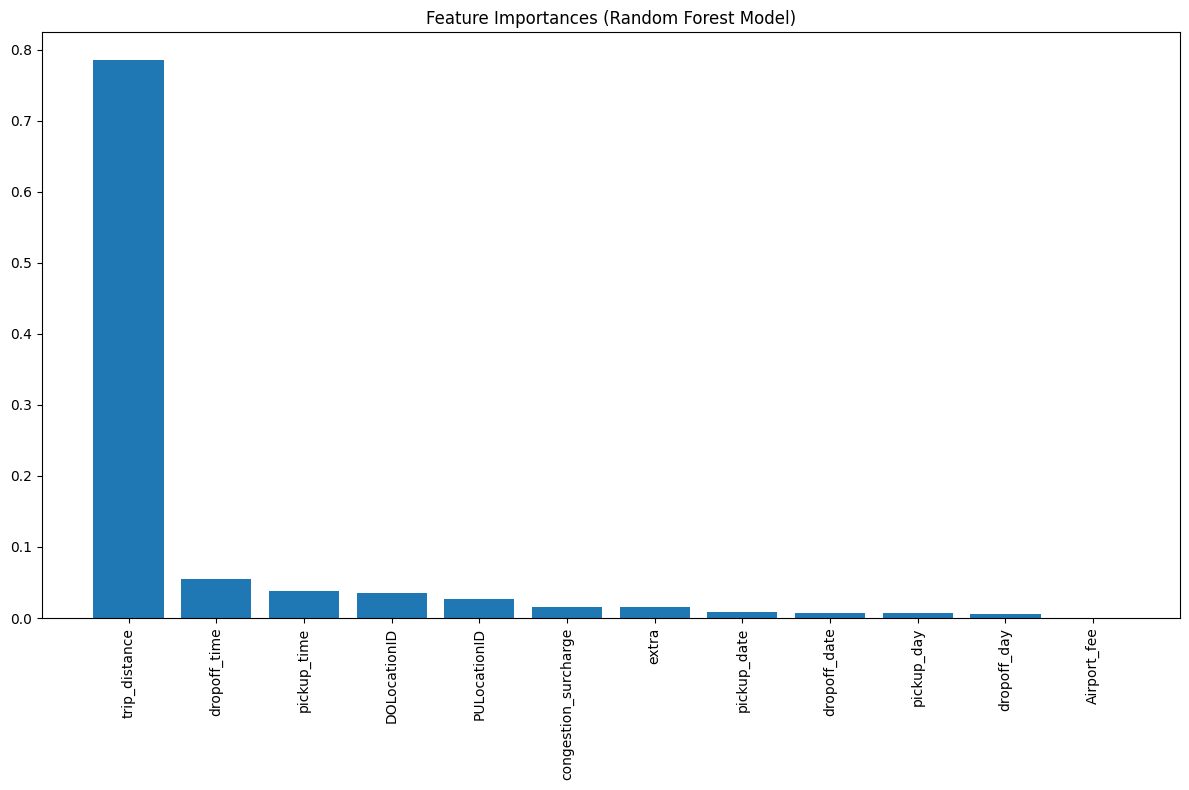


Feature importance ranking:
1. trip_distance: 0.7853
2. dropoff_time: 0.0556
3. pickup_time: 0.0379
4. DOLocationID: 0.0356
5. PULocationID: 0.0273
6. congestion_surcharge: 0.0157
7. extra: 0.0148
8. pickup_date: 0.0082
9. dropoff_date: 0.0074
10. pickup_day: 0.0067
11. dropoff_day: 0.0053
12. Airport_fee: 0.0001


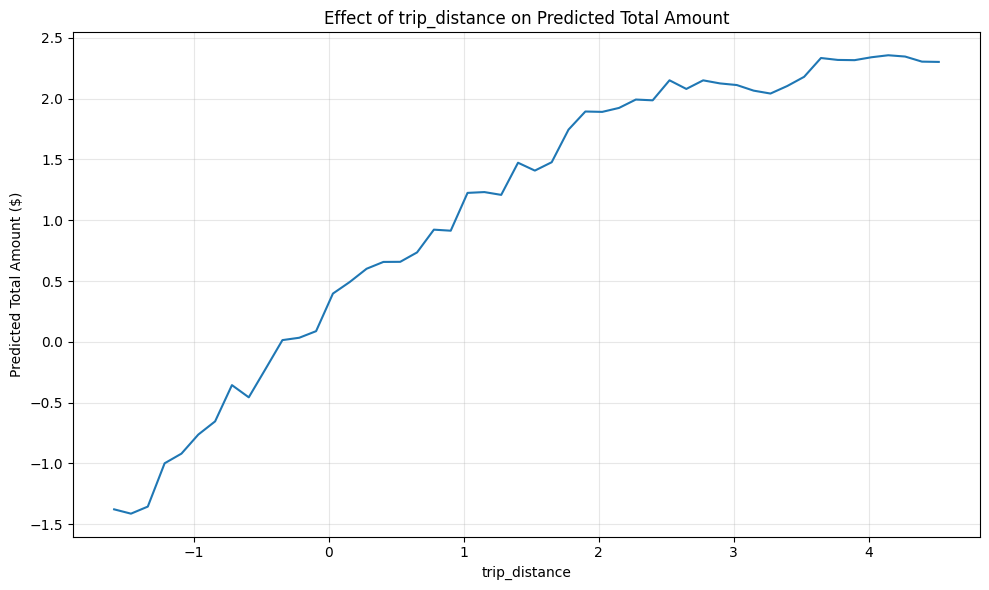

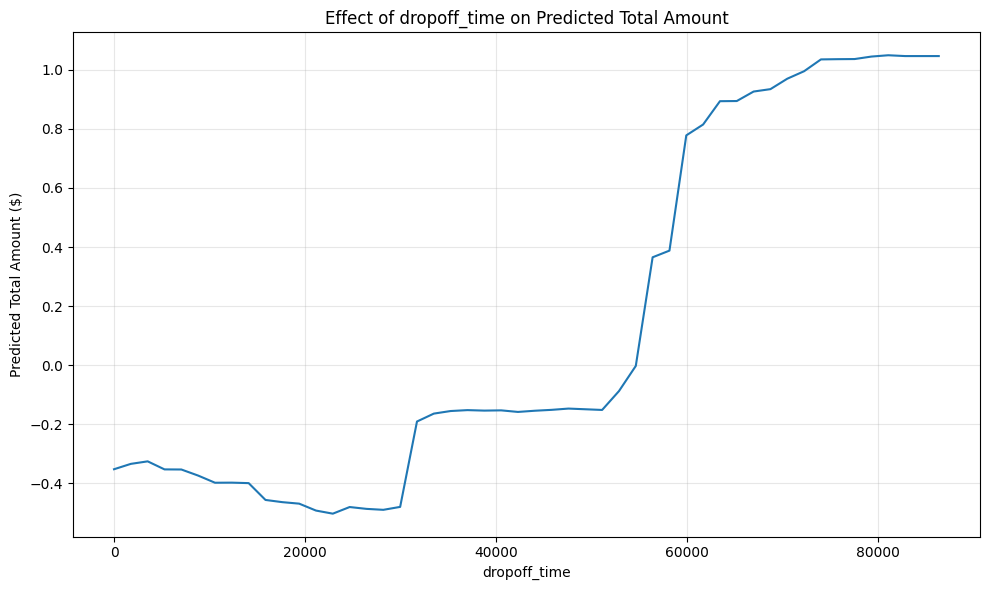

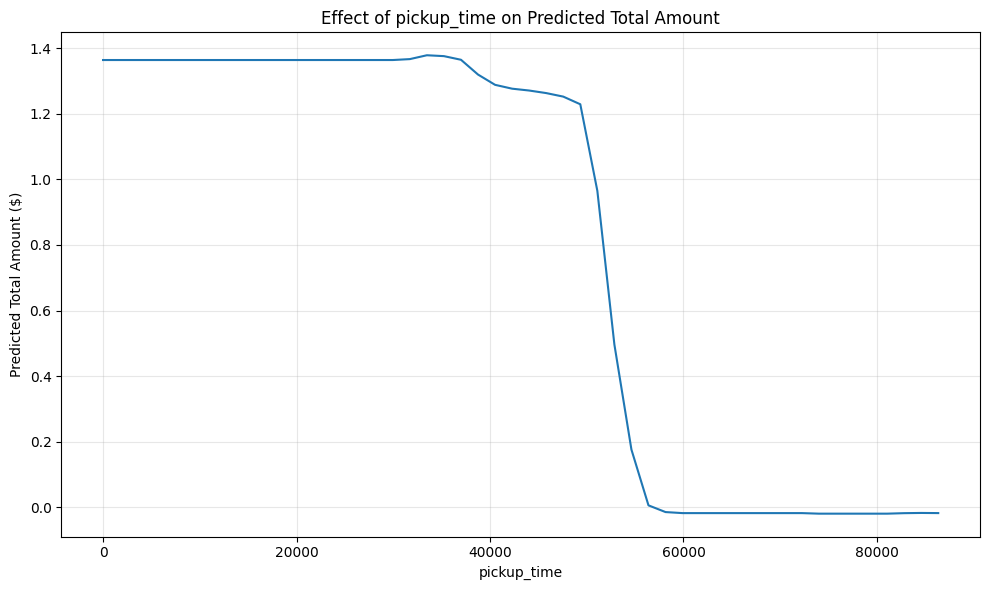

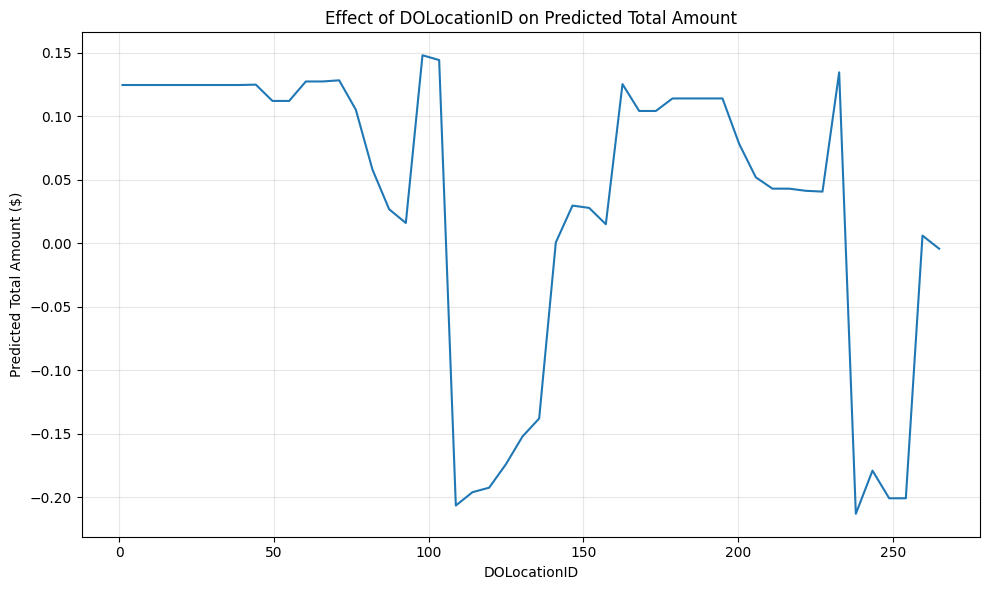

In [ ]:
# References:
# https://medium.com/@prasannarghattikar/using-random-forest-for-feature-importance-118462c40189
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# https://www.geeksforgeeks.org/feature-importance-with-random-forests/
# https://scikit-learn.org/stable/modules/permutation_importance.html
# https://scikit-learn.org/stable/modules/partial_dependence.html

# Feature importance visualization for best Random Forest model
plt.figure(figsize=(12, 8))

# Extract feature importance values from the trained Random Forest model
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

plt.title('Feature Importances (Random Forest Model)')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Print feature importances
print("\nFeature importance ranking:")
for i in range(len(feature_names)):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# Define function to plot individual feature effects (similar to partial dependence plots)
# This shows how predictions change when varying one feature while holding others constant
def plot_feature_effect(model, X, feature_name, n_points=50):
    """
    Parameters:
      model: Trained model with predict method
      X: DataFrame containing feature data
      feature_name: Name of the feature to analyze
      n_points: Number of points to evaluate for each feature value
    """
    plt.figure(figsize=(10, 6))

    # Get the index of the specified feature in the feature set
    feature_idx = list(X.columns).index(feature_name)

    # Get feature min and max values
    x_min, x_max = X[feature_name].min(), X[feature_name].max()
    x_range = np.linspace(x_min, x_max, n_points)

    # Create a baseline data point using the median values of all features
    X_sample = X.median().to_dict()
    samples = []

    # Create variations by changing only the target feature
    # while keeping all other features constant at their median values
    for x in x_range:
        sample = X_sample.copy()
        sample[feature_name] = x
        samples.append(sample)

    # Convert list of dictionaries to DataFrame for model prediction
    X_samples = pd.DataFrame(samples)

    # Generate predictions for each feature variation
    predictions = model.predict(X_samples)

    # Plot results
    plt.plot(x_range, predictions)
    plt.title(f'Effect of {feature_name} on Predicted Total Amount')
    plt.xlabel(feature_name)
    plt.ylabel('Predicted Total Amount ($)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize the effects of the top 4 most important features
for feature in [feature_names[i] for i in indices[:4]]:
    plot_feature_effect(best_rf, X_train, feature)

# Learning Curves
(show how model performance improves with more training data)

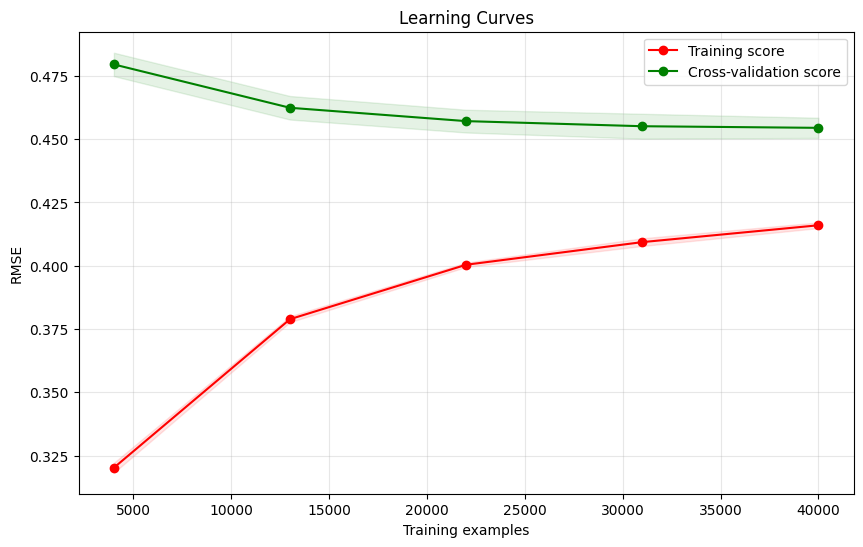

In [ ]:
# References:
# https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
# https://www.datacamp.com/tutorial/tutorial-learning-curves
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
# https://datascience.stackexchange.com/questions/103066/understanding-sklearns-learning-curve
# https://medium.com/@nesrine.ammar/how-learning-curve-function-from-scikit-learn-works-692d7d566d17
# https://www.dataquest.io/blog/learning-curves-machine-learning/
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
# https://stackoverflow.com/questions/55391460/how-to-plot-multiple-learning-curve-from-different-model-on-the-same-graph

from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))

    # Calculate learning curve data points using cross-validation
    # - estimator: Model to evaluate
    # - X, y: Feature matrix and target vector
    # - cv: Number of cross-validation folds
    # - n_jobs=-1: Use all available cores (unsure if this works on Google Colab)
    # - train_sizes: Points at which to evaluate model (fractions of full dataset)
    # - scoring: Metric to evaluate (negative because sklearn maximizes scores)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_root_mean_squared_error',
        random_state=42)

    # Process the scores
    # Convert negative scores to positive (for RMSE lower is better)
    # Calculate mean and standard deviation across cross-validation folds
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot confidence intervals (mean +- std) for training scores
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")

    # Plot confidence intervals for validation scores
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Plot mean scores for both training and validation
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # Chart labels and styling elements
    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)

    return plt # return the plot object

# Use a smaller subset for the learning curve to save computation time due to Google Colab (unsure if we need to)
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=min(50000, X.shape[0]), random_state=42)

# Generate learning curve for a simplified Random Forest model
# A simpler configuration is used to reduce computation time
# - n_estimators=50: Fewer trees than production model
# - max_depth=10: Limiting tree depth for faster training
simple_rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
plot_learning_curve(simple_rf, X_sample, y_sample)
plt.show()

# Compare With Project Proposal Objectives

In [ ]:
# References:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide
# https://medium.com/@abhishekjainindore24/a-comprehensive-guide-to-performance-metrics-in-machine-learning-4ae5bd8208ce
# https://www.purestorage.com/knowledge/machine-learning-performance-metrics.html

print("\n===== Project Evaluation =====")
print("\nComparison with Project Proposal Objectives:")

# Section 1: Evaluate model performance against initial goals
# Compare the achieved results with the project's original objectives
print("\n1. Model Performance:")
print(f"   - Best model RMSE: ${rmse_stacked:.2f}") # Final error metric
print(f"   - Best model R2: {r2_stacked:.4f}") # Variance explained by model
print("   - Objective from proposal: Build a model with RMSE significantly better than baseline")
# Calculate and display percentage improvement over baseline dummy regressor (maybe change it from dummy regressor?)
print(f"   - Improvement over baseline: {(dummy_rmse - rmse_stacked) / dummy_rmse * 100:.1f}%")

# Section 2: Analyze if identified important features align with our intuition
# This validates whether the model's learned patterns match expected taxi fare drivers
print("\n2. Feature Importance:")
print("   - According to our proposal, we expected trip distance, location, time of day to be key predictors")
print("   - Top actual predictors from model:")
# Display the top 5 (or fewer if dataset has fewer features) most important features
for i in range(min(5, len(feature_names))):
    print(f"     {i+1}. {feature_names[indices[i]]}")

# Section 3: Evaluate model selection choices against initial plan
# Compare actual implementation with proposed approach
print("\n3. Algorithm Selection:")
print("   - Proposal plan: Primarily use Random Forest with possible ensemble methods")
print("   - Implementation: Used Random Forest and enhanced with stacking ensemble")
# Calculate percentage improvement from base model to ensemble
print("   - The stacking ensemble improved performance by " +
      f"{((best_rf_r2 - r2_stacked) / best_rf_r2 * 100):.1f}% compared to tuned Random Forest")


===== Project Evaluation =====

Comparison with Project Proposal Objectives:

1. Model Performance:
   - Best model RMSE: $0.32
   - Best model R2: 0.8983
   - Objective from proposal: Build a model with RMSE significantly better than baseline
   - Improvement over baseline: 68.1%

2. Feature Importance:
   - According to our proposal, we expected trip distance, location, time of day to be key predictors
   - Top actual predictors from model:
     1. trip_distance
     2. dropoff_time
     3. pickup_time
     4. DOLocationID
     5. PULocationID

3. Algorithm Selection:
   - Proposal plan: Primarily use Random Forest with possible ensemble methods
   - Implementation: Used Random Forest and enhanced with stacking ensemble
   - The stacking ensemble improved performance by -7.3% compared to tuned Random Forest
